# Sarcasm Detector

#### The dataset
News Headlines dataset for Sarcasm Detection is collected from two news websites. TheOnion aims at producing sarcastic versions of current and humorous stories. While it may look like real news at a glance, everything they publish is intentionally fake. Real (and non-sarcastic) news headlines are collected from HuffPost.

Each record consists of three attributes:
- is_sarcastic: 1 

- if the record is sarcastic otherwise 0

headline: the headline of the news article

article_link: link to the original news article. Useful in collecting supplementary data


#### Import statements

In [7]:
import re
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns

from tqdm.auto import tqdm

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

import nltk
import contractions

from transformers import pipeline, DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset, load_dataset
import evaluate
from evaluate import evaluator

nltk.download("punkt")



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kristinaliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Function definitions

In [16]:
def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    
    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs

def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):

    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    embeddings_index = dict(get_coefs(*row.split(" "))
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore')
                                    if len(row)>100)

    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))

    for word, idx in word_to_index.items():
        if idx >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

def gen_prediction(model, x_test, y_test):
    predictions = model.predict(x_test, batch_size=2048, verbose=0).ravel()
    predictions = [1 if prob > 0.5 else 0 for prob in predictions]
    acc = accuracy_score(y_test, predictions)*100
    print(f"Accuracy: {acc:.2f}")
    print(classification_report(y_test, predictions))
    labels = ['not sarcastic', 'sarcastic']
    print(pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels))

    return acc

#### Get and Load Data

In [10]:
!gdown 1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz

Downloading...
From: https://drive.google.com/uc?id=1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz
To: /Users/kristinaliu/Documents/NLP/SarcasmDetect.json
100%|██████████████████████████████████████| 6.06M/6.06M [00:01<00:00, 3.04MB/s]


#### Import data

In [11]:
df = pd.read_json('./SarcasmDetect.json', lines=True)
df.sample(5)

,is_sarcastic,headline,article_link
9140,1,kate middleton suffering from morning sickness,https://www.theonion.com/kate-middleton-suffer...
25748,0,how to take your dream vacation without a guid...,https://www.huffingtonpost.com/entry/vacation-...
26043,0,u.s. tourist was detained in north korea for ...,https://www.huffingtonpost.com/entry/jeffrey-f...
3302,0,"7 tips to exchange gifts and save stress, money",https://www.huffingtonpost.comhttp://pubx.co/e...
28337,0,how some of trump's bad tweets are helping pup...,https://www.huffingtonpost.com/entry/trump-and...


#### Remove all records with no headline text

In [12]:
df = df[df['headline'] != '']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


Define X and y

In [13]:
corpus = df['headline']
y = df['is_sarcastic']

In [14]:
y.value_counts(normalize=True)

is_sarcastic
0    0.523603
1    0.476397
Name: proportion, dtype: float64

## Text preprocessing

#### Normalize corpus

In [17]:
corpus_clean = normalize_corpus(corpus)

100%|██████████| 28619/28619 [00:00<00:00, 138022.02it/s]


#### Train-test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(corpus_clean, y, test_size=0.3, random_state=42)

#### TF-IDF vectorizer

In [19]:
tv = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0, ngram_range=(1,2))
tv_xtrain = tv.fit_transform(X_train)
tv_xtest = tv.transform(X_test)

## ML models

### Baseline logistic regression

In [20]:
# instantiate model
model_lr = LogisticRegression(penalty='l2', max_iter=500, C=1,
                        solver='lbfgs', random_state=42)

In [21]:
model_lr.fit(tv_xtrain, y_train.values)
tfidf_predictions_lr = model_lr.predict(tv_xtest)

/Users/kristinaliu/Applications/anaconda3/envs/llm_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [22]:
labels = ['not sarcastic', 'sarcastic']
acc_lr = accuracy_score(y_test, tfidf_predictions_lr)*100
print(classification_report(y_test, tfidf_predictions_lr))
pd.DataFrame(confusion_matrix(y_test, tfidf_predictions_lr), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4455
           1       0.82      0.83      0.83      4131

    accuracy                           0.83      8586
   macro avg       0.83      0.83      0.83      8586
weighted avg       0.83      0.83      0.83      8586



,not sarcastic,sarcastic
not sarcastic,3712,743
sarcastic,702,3429


### Random forest model

In [23]:
# instantiate model
model_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# train model
model_rf.fit(tv_xtrain, y_train)

# predict on test data
tfidf_predictions_rf = model_rf.predict(tv_xtest)

In [24]:
labels = ['not sarcastic', 'sarcastic']
acc_rf = accuracy_score(y_test, tfidf_predictions_rf)*100
print(classification_report(y_test, tfidf_predictions_rf))
pd.DataFrame(confusion_matrix(y_test, tfidf_predictions_rf), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      4455
           1       0.78      0.82      0.80      4131

    accuracy                           0.80      8586
   macro avg       0.80      0.80      0.80      8586
weighted avg       0.80      0.80      0.80      8586



,not sarcastic,sarcastic
not sarcastic,3476,979
sarcastic,732,3399


### XGBoost

In [25]:
model_xgb = xgb.XGBClassifier(n_jobs=-1)

In [26]:
model_xgb.fit(tv_xtrain, y_train)
predictions_xgb = model_xgb.predict(tv_xtest)

In [27]:
labels = ['not sarcastic', 'sarcastic']
acc_xgb = accuracy_score(y_test, predictions_xgb)*100
print(classification_report(y_test, predictions_xgb))
pd.DataFrame(confusion_matrix(y_test, predictions_xgb), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.84      0.74      0.78      4455
           1       0.75      0.84      0.79      4131

    accuracy                           0.79      8586
   macro avg       0.79      0.79      0.79      8586
weighted avg       0.79      0.79      0.79      8586



,not sarcastic,sarcastic
not sarcastic,3288,1167
sarcastic,643,3488


## Deep learning models
### Preprocess text for DL models

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence


In [33]:
# Tokenize sequences
t = Tokenizer(oov_token='<UNK>')
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0
train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=22132
Number of Documents=20033


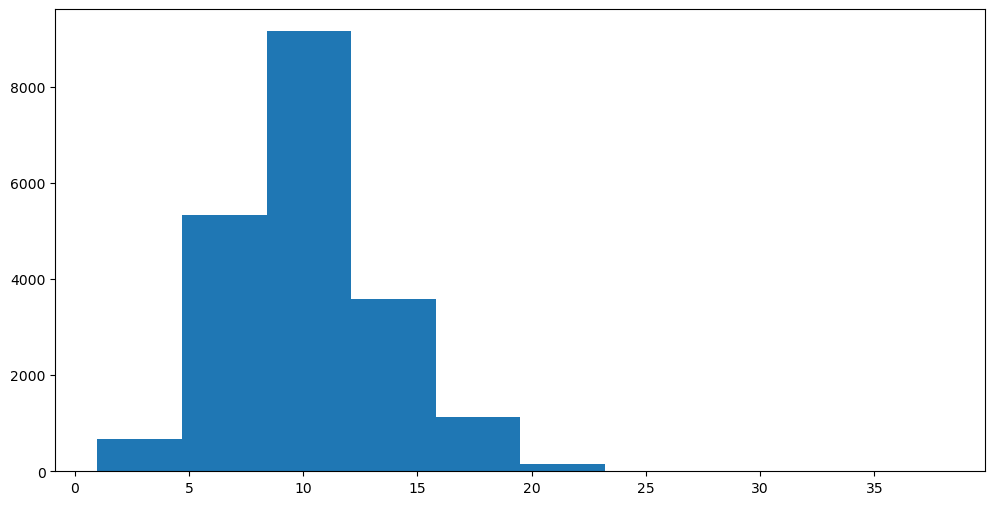

In [34]:
# Visualise length of each sequence
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]

fig, ax = plt.subplots(1,1, figsize=(12, 6))
h1 = ax.hist(train_lens)

In [35]:
# Pad sequences to sensible length observed in plt
MAX_SEQUENCE_LENGTH = 23
X_train_pad = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_pad = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH,  padding='post')
X_train_pad.shape, X_test_pad.shape

((20033, 23), (8586, 23))

In [36]:
# Parameters for embedding layer
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300 # word embedding size

#### Training parameters

In [37]:
# Parameters for model training
EPOCHS=20
BATCH_SIZE=128

# Callback for early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=5,
                                      restore_best_weights=True,
                                      verbose=1)

### CNN

In [38]:
# create the model
model_cnn = Sequential(name='CNN')

model_cnn.add(Embedding(VOCAB_SIZE,
                    EMBED_SIZE,
                    input_length=MAX_SEQUENCE_LENGTH))

model_cnn.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Flatten())

model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(tf.keras.layers.Dropout(0.25))
model_cnn.add(tf.keras.layers.Dense(256, activation='relu'))
model_cnn.add(tf.keras.layers.Dropout(0.25))

model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_cnn.summary()

/Users/kristinaliu/Applications/anaconda3/envs/llm_env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model
model_cnn.fit(X_train_pad, y_train,
          validation_split=0.2,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          callbacks=[es],
          verbose=1)

Epoch 1/20


In [57]:
acc_cnn = gen_prediction(model_cnn, X_test_pad, y_test)

Accuracy: 84.95
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      4455
           1       0.81      0.89      0.85      4131

    accuracy                           0.85      8586
   macro avg       0.85      0.85      0.85      8586
weighted avg       0.85      0.85      0.85      8586

               not sarcastic  sarcastic
not sarcastic           3617        838
sarcastic                454       3677


#### Use FastText embedding

In [28]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = Path('..', 'embeddings', 'crawl-300d-2M-subword.vec')

In [29]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx,
                                           max_features=VOCAB_SIZE,
                                           embedding_size=EMBED_SIZE,
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

(22132, 300)

In [ ]:
# Using same model than in live coding 
model_cnn_ft = tf.keras.models.Sequential(name='CNN-FastText')

model_cnn_ft.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model_cnn_ft.add(tf.keras.layers.Conv1D(filters=256, kernel_size=4, padding='same', activation='relu'))
model_cnn_ft.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model_cnn_ft.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model_cnn_ft.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model_cnn_ft.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model_cnn_ft.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model_cnn_ft.add(tf.keras.layers.Flatten())

model_cnn_ft.add(tf.keras.layers.Dense(256, activation='relu'))
model_cnn_ft.add(tf.keras.layers.Dropout(0.25))
model_cnn_ft.add(tf.keras.layers.Dense(256, activation='relu'))
model_cnn_ft.add(tf.keras.layers.Dropout(0.25))
model_cnn_ft.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_cnn_ft.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_ft.summary()

In [31]:
model_cnn_ft.fit(X_train_pad, y_train,
          validation_split=0.2,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          callbacks=[es],
          verbose=1)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6777 - loss: 0.5580 - val_accuracy: 0.8682 - val_loss: 0.3148
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9466 - loss: 0.1516 - val_accuracy: 0.8700 - val_loss: 0.3578
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9901 - loss: 0.0327 - val_accuracy: 0.8538 - val_loss: 0.5341
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9964 - loss: 0.0117 - val_accuracy: 0.8550 - val_loss: 0.6673
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9980 - loss: 0.0060 - val_accuracy: 0.8495 - val_loss: 0.9268
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9966 - loss: 0.0087 - val_accuracy: 0.8510 - val_loss: 0.7140
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [58]:
acc_cnn_ft = gen_prediction(model_cnn_ft, X_test_pad, y_test)

Accuracy: 86.48
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      4455
           1       0.87      0.84      0.86      4131

    accuracy                           0.86      8586
   macro avg       0.87      0.86      0.86      8586
weighted avg       0.87      0.86      0.86      8586

               not sarcastic  sarcastic
not sarcastic           3958        497
sarcastic                664       3467


### LSTM

In [33]:
LSTM_DIM = 128 # the number of hidden units in each LSTM cell i.e the hidden state embedding size;

model_lstm = tf.keras.models.Sequential(name="LSTM")

model_lstm.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))) # to use bidirectional lstms

# model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model_lstm.add(tf.keras.layers.Dense(256, activation='relu'))

model_lstm.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model_lstm.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model_lstm.summary()

/home/janp/miniforge3/envs/nlp3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     6,639,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,639,600 (25.33 MB)

 Trainable params: 6,639,600 (25.33 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model_lstm.fit(X_train_pad, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
          callbacks=[es],
          shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7195 - loss: 0.5174 - val_accuracy: 0.8453 - val_loss: 0.3430
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9326 - loss: 0.1765 - val_accuracy: 0.8612 - val_loss: 0.3551
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9816 - loss: 0.0621 - val_accuracy: 0.8485 - val_loss: 0.4663
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9947 - loss: 0.0191 - val_accuracy: 0.8455 - val_loss: 0.5885
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9968 - loss: 0.0119 - val_accuracy: 0.8395 - val_loss: 0.8129
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9959 - loss: 0.0103 - val_accuracy: 0.8340 - val_loss: 0.8624
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [59]:
acc_lstm = gen_prediction(model_lstm, X_test_pad, y_test)

Accuracy: 85.16
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      4455
           1       0.80      0.93      0.86      4131

    accuracy                           0.85      8586
   macro avg       0.86      0.85      0.85      8586
weighted avg       0.86      0.85      0.85      8586

               not sarcastic  sarcastic
not sarcastic           3488        967
sarcastic                307       3824


### GRU

In [37]:
GRU_DIM = 1024 # the number of hidden units in each LSTM cell i.e the hidden state embedding size;

model_gru = tf.keras.models.Sequential(name="GRU")

model_gru.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))
model_gru.add(tf.keras.layers.Dropout(0.5))

model_gru.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(GRU_DIM, return_sequences=True))) # to use bidirectional lstms
model_gru.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(GRU_DIM, return_sequences=False))) # to use bidirectional lstms

# model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model_gru.add(tf.keras.layers.Dense(256, activation='relu'))
# model_gru.add(tf.keras.layers.Dropout(0.2))
model_gru.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model_gru.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model_gru.summary()

/home/janp/miniforge3/envs/nlp3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     6,639,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,639,600 (25.33 MB)

 Trainable params: 6,639,600 (25.33 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model_gru.fit(X_train_pad, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
          callbacks=[es],
          shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.7293 - loss: 0.5213 - val_accuracy: 0.8568 - val_loss: 0.3472
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9109 - loss: 0.2195 - val_accuracy: 0.8643 - val_loss: 0.3236
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9603 - loss: 0.1074 - val_accuracy: 0.8563 - val_loss: 0.3955
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9793 - loss: 0.0571 - val_accuracy: 0.8473 - val_loss: 0.5352
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9884 - loss: 0.0331 - val_accuracy: 0.8373 - val_loss: 0.5205
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9910 - loss: 0.0266 - val_accuracy: 0.8368 - val_loss: 0.7569
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9950 - loss: 0.0143 - val_accuracy: 0.8373 - val_loss: 0.8124
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [60]:
acc_gru = gen_prediction(model_gru, X_test_pad, y_test)

Accuracy: 86.98
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      4455
           1       0.86      0.87      0.87      4131

    accuracy                           0.87      8586
   macro avg       0.87      0.87      0.87      8586
weighted avg       0.87      0.87      0.87      8586

               not sarcastic  sarcastic
not sarcastic           3876        579
sarcastic                539       3592


## Transformers

### BERT

In [42]:
def create_bert_input_features(tokenizer, docs, max_seq_length):

    all_ids, all_masks, all_segments= [], [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):

        tokens = tokenizer.tokenize(doc)

        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        # with newer versions of transformers you don't need to explicitely add CLS and SEP
        # they are automatically added by the tokenizer
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids) # [1,1,1.....] # < 500 ones

        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)

        segments = [0] * max_seq_length # [0,0,0...] # 500 zeros
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)

    encoded = np.array([all_ids, all_masks, all_segments])

    return encoded

In [43]:
# Tokenize
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(corpus_clean, y, train_size=0.7, random_state=42)

In [44]:
train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer,
                                                                                               X_train,
                                                                                               max_seq_length=MAX_SEQUENCE_LENGTH)

test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer,
                                                                                               X_test,
                                                                                               max_seq_length=MAX_SEQUENCE_LENGTH)

Converting docs to features: 100%|██████████| 8586/8586 [00:00<00:00, 9989.54it/s] 


In [46]:
# Build BERT model
bert_model = transformers.TFBertModel.from_pretrained('bert-base-uncased')

inp_id = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="bert_segment_ids")
inputs = [inp_id, inp_mask, inp_segment]

def bert_layer(inputs):
    return bert_model(input_ids=inputs[0], attention_mask=inputs[1], token_type_ids=inputs[2])

bert_outputs = tf.keras.layers.Lambda(bert_layer, output_shape=(MAX_SEQUENCE_LENGTH, 768))([inp_id, inp_mask, inp_segment])

pooled_output = bert_outputs[1]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model_bert = tf.keras.Model(inputs=[inp_id, inp_mask, inp_segment], outputs=output)
model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5,
                                           epsilon=1e-08),
              loss='binary_crossentropy', metrics=['accuracy'])

model_bert.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ bert_input_ids      │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_input_masks    │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_segment_ids    │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 23, 768)   │          0 │ bert_input_ids[0… │
│                     │                   │            │ bert_input_masks… │
│                     │                   │            │ bert_segment_ids… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (23, 768)         │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (23, 256)         │    196,864 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (23, 256)         │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (23, 256)         │     65,792 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (23, 256)         │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (23, 1)           │        257 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 262,913 (1.00 MB)

 Trainable params: 262,913 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model_bert.fit([train_features_ids,
           train_features_masks,
           train_features_segments], y_train, 
           validation_split=0.2, epochs=20,
           batch_size=15,
           shuffle=True,
           verbose=1)

Epoch 1/20


W0000 00:00:1740757295.437490  363940 assert_op.cc:38] Ignoring Assert operator functional_4_1/lambda_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
2025-02-28 16:41:37.586074: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 32 bytes spill stores, 32 bytes spill loads

2025-02-28 16:41:37.776630: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 340 bytes spill stores, 308 bytes spill loads

2025-02-28 16:41:38.020409: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12431', 64 bytes spill stores, 64 bytes spill loads

2025-02-28 16:41:38.274055: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled 

1066/1069 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5535 - loss: 0.6881

W0000 00:00:1740757306.771994  363935 assert_op.cc:38] Ignoring Assert operator functional_4_1/lambda_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
2025-02-28 16:41:48.185569: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 32 bytes spill stores, 32 bytes spill loads

2025-02-28 16:41:48.256741: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 340 bytes spill stores, 308 bytes spill loads

2025-02-28 16:41:48.815557: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7_0', 1548 bytes spill stores, 1804 bytes spill loads

2025-02-28 16:41:48.936885: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spille

1069/1069 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5536 - loss: 0.6880

W0000 00:00:1740757311.881280  363935 assert_op.cc:38] Ignoring Assert operator functional_4_1/lambda_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1740757315.552479  363938 assert_op.cc:38] Ignoring Assert operator functional_4_1/lambda_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
2025-02-28 16:41:56.440321: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2', 32 bytes spill stores, 32 bytes spill loads

2025-02-28 16:41:56.560082: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2_0', 124 bytes spill stores, 132 bytes spill loads

2025-02-28 16:41:56.563520: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2', 340 bytes spill stores, 3

1069/1069 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.5536 - loss: 0.6880 - val_accuracy: 0.7108 - val_loss: 0.6063
Epoch 2/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6685 - loss: 0.6154 - val_accuracy: 0.7562 - val_loss: 0.5489
Epoch 3/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7147 - loss: 0.5677 - val_accuracy: 0.7587 - val_loss: 0.5210
Epoch 4/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7361 - loss: 0.5360 - val_accuracy: 0.7764 - val_loss: 0.5017
Epoch 5/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7581 - loss: 0.5147 - val_accuracy: 0.7731 - val_loss: 0.4951
Epoch 6/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7599 - loss: 0.5010 - val_accuracy: 0.7856 - val_loss: 0.4775
Epoch 7/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7667 - loss: 0.4890 - val_accuracy: 0.7764 - val_loss: 0.4752
Epoch 8/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7694 - loss: 0.4772 - val_accu

In [50]:
acc_bert = gen_prediction(model_bert, [test_features_ids,
           test_features_masks,
           test_features_segments], y_test)

W0000 00:00:1740757546.999251  363939 assert_op.cc:38] Ignoring Assert operator functional_4_1/lambda_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
2025-02-28 16:45:47.811018: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2554', 264 bytes spill stores, 264 bytes spill loads

2025-02-28 16:45:47.853763: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2554', 68 bytes spill stores, 68 bytes spill loads

2025-02-28 16:45:48.127753: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2554_0', 776 bytes spill stores, 724 bytes spill loads

2025-02-28 16:45:48.226881: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are

Accuracy: 80.84
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      4455
           1       0.79      0.81      0.80      4131

    accuracy                           0.81      8586
   macro avg       0.81      0.81      0.81      8586
weighted avg       0.81      0.81      0.81      8586

               not sarcastic  sarcastic
not sarcastic           3585        870
sarcastic                775       3356


## Visualise results

In [ ]:
acc_list = [acc_lr, acc_rf, acc_xgb, acc_cnn, acc_cnn_ft, acc_lstm, acc_gru, acc_bert]
acc_labels = ["LogisticRegression", "RandomForest", "XGBoost", "CNN", "CNNFastText", "LSTM", "GRU", "BERT"]
acc_dict = {k: v for k, v in zip(acc_labels, acc_list)} 
df_acc = pd.DataFrame(acc_dict, index=range(0, 1)).melt()

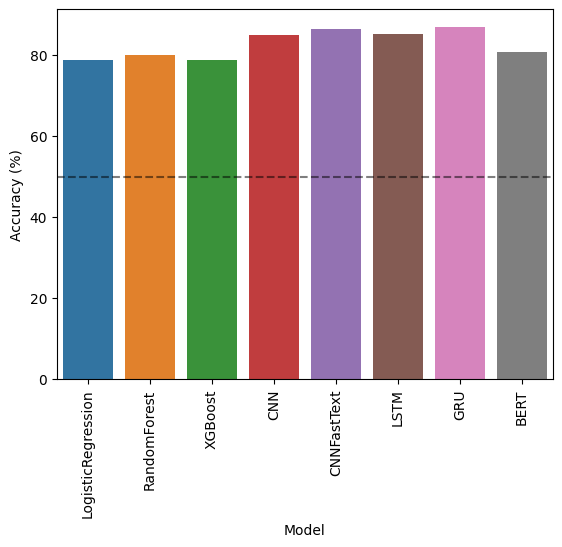

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.barplot(df_acc, x="variable", y="value", hue="variable")
ax.set_xticks(acc_labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy (%)")
ax.axhline(50, linestyle="--", color="k", alpha=0.5)
None